# Ungraded Lab: Data Augmentation on the Horses or Humans Dataset

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/TensorFlow_Developer_Professional_Certificate/blob/master/Convolutional_Neural_Networks_in_TensorFlow/Week2/Labs/C2_W2_Lab_2_horses_v_humans_augmentation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

In the previous lab, you saw how data augmentation helped improve the model's performance on unseen data. By tweaking the cat and dog training images, the model was able to learn features that are also representative of the validation data. However, applying data augmentation requires good understanding of your dataset. Simply transforming it randomly will not always yield good results. 

In the next cells, you will apply the same techniques to the `Horses or Humans` dataset and analyze the results.

In [1]:
%%bash

# Download the training set
wget -q https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

# Download the validation set
wget -q https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip

In [2]:
import os
import zipfile
from keras import Input, Sequential, layers, optimizers, utils
import matplotlib.pyplot as plt
import seaborn as sns

2024-06-12 20:44:01.602695: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Extract the archive
zip_ref = zipfile.ZipFile('./horse-or-human.zip', 'r')
zip_ref.extractall('./horse-or-human')

zip_ref = zipfile.ZipFile('./validation-horse-or-human.zip', 'r')
zip_ref.extractall('./validation-horse-or-human')

zip_ref.close()

# Directory with training horse pictures
train_horse_dir = os.path.join('./horse-or-human/horses')

# Directory with training human pictures
train_human_dir = os.path.join('./horse-or-human/humans')

# Directory with validation horse pictures
validation_horse_dir = os.path.join('./validation-horse-or-human/horses')

# Directory with validation human pictures
validation_human_dir = os.path.join('./validation-horse-or-human/humans')

In [4]:
# Apply data augmentation
augmentation = Sequential([layers.RandomRotation(factor=0.2, fill_mode="nearest"),
                           layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="nearest"),
                           layers.RandomZoom(height_factor=0.2, width_factor=0.2, fill_mode="nearest"),
                           layers.RandomFlip(mode="horizontal")])

# Build the model
model = Sequential([Input(shape=(300, 300, 3)),
                    augmentation,
                    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
                    # This is the first convolution
                    layers.Conv2D(16, (3, 3), activation='relu'),
                    layers.MaxPooling2D(2, 2),
                    # The second convolution
                    layers.Conv2D(32, (3, 3), activation='relu'),
                    layers.MaxPooling2D(2, 2),
                    # The third convolution
                    layers.Conv2D(64, (3, 3), activation='relu'),
                    layers.MaxPooling2D(2, 2),
                    # The fourth convolution
                    layers.Conv2D(64, (3, 3), activation='relu'),
                    layers.MaxPooling2D(2, 2),
                    # The fifth convolution
                    layers.Conv2D(64, (3, 3), activation='relu'),
                    layers.MaxPooling2D(2, 2),
                    # Flatten the results to feed into a DNN
                    layers.Flatten(),
                    # 512 neuron hidden layer
                    layers.Dense(512, activation='relu'),
                    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
                    layers.Dense(1, activation='sigmoid')])

2024-06-12 20:44:04.230550: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1588 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [5]:
# Set training parameters
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

In [6]:
# All images will be rescaled by 1./255
scale = layers.Rescaling(scale=1. / 255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = utils.image_dataset_from_directory(directory="./horse-or-human/", # This is the source directory for training images
                                                     image_size=(300, 300), # All images will be resized to 300x300
                                                    #  batch_size=128,
                                                     label_mode='binary') # Since we use binary_crossentropy loss, we need binary labels

# Flow training images in batches of 128 using train_datagen generator
validation_generator = utils.image_dataset_from_directory(directory="./validation-horse-or-human/", # This is the source directory for validation images
                                                          image_size=(300, 300), # All images will be resized to 300x300
                                                        #   batch_size=32,
                                                          label_mode='binary') # Since we use binary_crossentropy loss, we need binary labels

train_generator = train_generator.map(lambda image, label: (scale(image), label))
validation_generator = validation_generator.map(lambda image, label: (scale(image), label))

Found 1027 files belonging to 2 classes.
Found 256 files belonging to 2 classes.


In [7]:
# Constant for epochs
EPOCHS = 20

# Train the model
history = model.fit(
                    train_generator,
                    # steps_per_epoch=8,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=validation_generator,
                    # validation_steps=8
                    )

Epoch 1/20


2024-06-12 20:44:08.585989: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.5559 - loss: 0.6831 - val_accuracy: 0.4961 - val_loss: 0.6662
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.6495 - loss: 0.6496 - val_accuracy: 0.5000 - val_loss: 0.7267
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.6520 - loss: 0.6274 - val_accuracy: 0.5000 - val_loss: 1.1960
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.6979 - loss: 0.5824 - val_accuracy: 0.5195 - val_loss: 0.5558
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.7030 - loss: 0.5976 - val_accuracy: 0.5312 - val_loss: 0.7557
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.6965 - loss: 0.5766 - val_accuracy: 0.5469 - val_loss: 0.7433
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.7539 - loss: 0.5155 - val_accuracy: 0.5195 - val_loss: 1.1704
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.7518 - loss: 0.5274 - val_accuracy: 0.5117 - val_loss: 

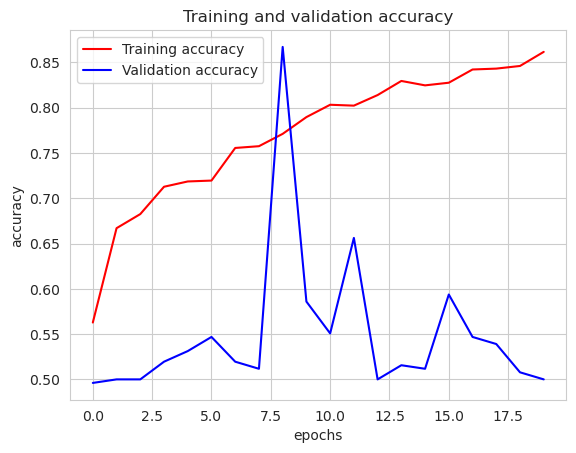

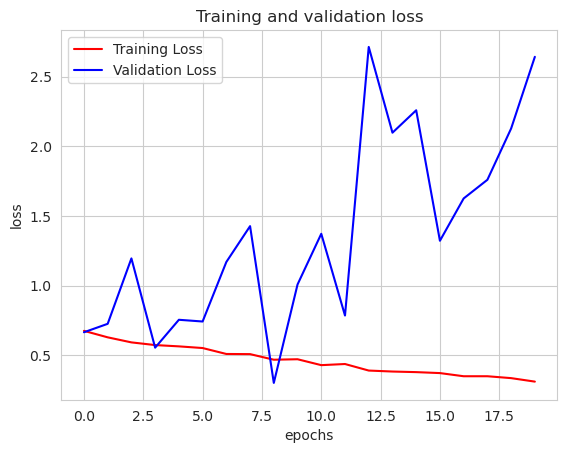

In [8]:
sns.set_style("whitegrid")

# Plot the model results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure()
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

As you can see in the results, the preprocessing techniques used in augmenting the data did not help much in the results. The validation accuracy is fluctuating and not trending up like the training accuracy. This might be because the additional training data generated still do not represent the features in the validation data. For example, some human or horse poses in the validation set cannot be mimicked by the image processing techniques that `ImageDataGenerator` provides. It might also be that the background of the training images are also learned so the white background of the validation set is throwing the model off even with cropping. Try looking at the validation images in the `tmp/validation-horse-or-human` directory (note: if you are using Colab, you can use the file explorer on the left to explore the images) and see if you can augment the training images to match its characteristics. If this is not possible, then at this point you can consider other techniques and you will see that in next week's lessons.

In [9]:
!rm -rf *.zip ./horse* ./validation*